# Convolutional autoencoder (AE) for DICOM x-ray image denoising

## Set up environment

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Import necessary libraries and packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from google.colab.patches import cv2_imshow
import skimage
from skimage import data
from skimage import util
from skimage.filters.rank import gradient
from skimage.color import rgb2gray
from skimage.morphology import disk
from scipy import ndimage, misc
import scipy.misc

from PIL import Image, ImageOps

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, UpSampling2D
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, Conv2D, Reshape, Conv2DTranspose
#from tensorflow.keras.layers import Dense, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import distribute

from sklearn.model_selection import train_test_split
from skimage import data
from skimage.filters.rank import gradient
from skimage.color import rgb2gray
from skimage.morphology import disk

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error, mean_squared_error, normalized_root_mse

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
#print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.2
Eager mode:  True
GPU is NOT AVAILABLE


## Install pydicom

In [5]:
!pip install pydicom
import pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


## Connect google colab with drive

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Reading in the DICOM images: Load the dataset

### Low dose, high intensity image

In [7]:
#LOW DOSE IMAGE
imagepath = '/content/gdrive/My Drive/DICOM/NoGrid/1.25xClinDose/DICOM/0001003A' #1.25x clinical dose - noisiest

data = pydicom.dcmread(imagepath) 

print(data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Processing
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.51.0.7.12817866491.56865.6464.42903.31758.56033.24603
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.51.0.1.3
(0002, 0013) Implementation Version Name         SH: 'AGFA DTF1.0.95'
(0002, 0016) Source Application Entity Title     AE: 'AE_AGFA_NX'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'FLAT FIELD 200']
(0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Processing
(0008, 0018) SOP Instance UID                    UI: 1.3.51.0.7.12817866491.56865.6464.42903.31

6631180 13755 174
----------1.25x clinicalNoGrid----------
| original image size: 6631180 |
| maximum: 13755 |
| minimum: 174 |
---------------------------------


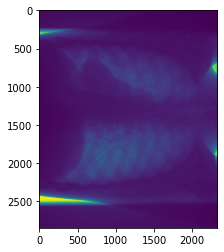

In [8]:
reference = data.pixel_array

#Print size
refsize = reference.size
refmax = np.max(reference)
refmin = np.min(reference)
print(refsize,refmax,refmin)  
 
#show the image
print('----------1.25x clinicalNoGrid----------')
print('| original image size: %d'%(refsize), '|')
print('| maximum: %d'%(refmax), '|')
print('| minimum: %d'%(refmin), '|')
print('---------------------------------')
plt.imshow(reference/refmax)
plt.show()

### High dose, low intensity image

In [9]:
imagepath_hd = '/content/gdrive/My Drive/DICOM/NoGrid/3.2xClinDose/DICOM/0001003A' #3.2x clinical dose - least noisy

data_hd = pydicom.read_file(imagepath_hd)

print(data_hd)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Processing
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.51.0.7.3402066653.52720.31044.46693.37855.46215.31622
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.51.0.1.3
(0002, 0013) Implementation Version Name         SH: 'AGFA DTF1.0.95'
(0002, 0016) Source Application Entity Title     AE: 'AE_AGFA_NX'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'FLAT FIELD 200']
(0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Processing
(0008, 0018) SOP Instance UID                    UI: 1.3.51.0.7.3402066653.52720.31044.46693.37

6631180 34436 489
--------3.2x clinicalNoGrid------------
| original image size: 6631180 |
| maximum: 34436 |
| minimum: 489 |
---------------------------------


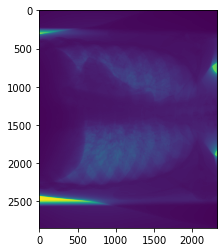

In [10]:
hd_reference = data_hd.pixel_array

#Print size
hdrefsize = hd_reference.size
hdrefmax = np.max(hd_reference)
hdrefmin = np.min(hd_reference)
print(hdrefsize, hdrefmax, hdrefmin)  

#show the image
print('--------3.2x clinicalNoGrid------------')
print('| original image size: %d'%(hdrefsize), '|')
print('| maximum: %d'%(hdrefmax), '|')
print('| minimum: %d'%(hdrefmin), '|')
print('---------------------------------')
plt.imshow(hd_reference/hdrefmax)
plt.show()

## Define 'slices' of the image for computational efficiency

### 1st slice for low dose image

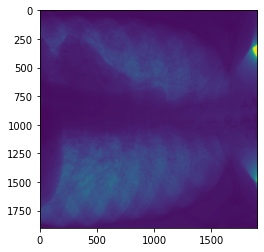

In [11]:
ref = reference[400:2300, 400:2300]
np.shape(ref)
plt.imshow(ref/np.max(ref))
plt.show()

### 2nd slice for high dose image

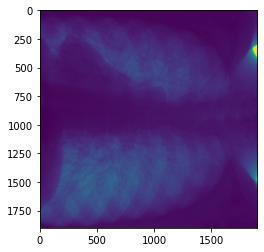

In [12]:
hd_ref = hd_reference[400:2300, 400:2300]
np.shape(hd_ref)
plt.imshow(hd_ref/np.max(hd_ref))
plt.show()

### Find out size of 1st image and 2nd image

current image size: 1900 x 1900


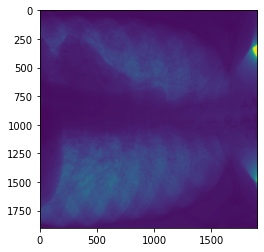

In [13]:
width, height = ref.shape  

print("current image size: %d x %d"%(width, height))

#show the image
plt.imshow(ref)
plt.show()

current image size: 1900 x 1900


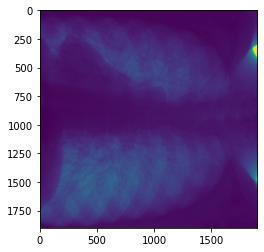

In [14]:
width, height = hd_ref.shape  

print("current image size: %d x %d"%(width, height))

#show the image
plt.imshow(hd_ref)
plt.show()

### Convert ref and hd_ref to an np array

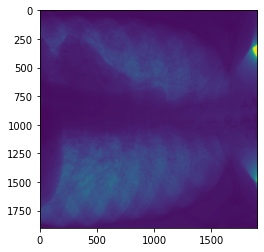

In [15]:
mywidth = 1900 #width
myheight = 1900 #height

#convert to an np array
ref = np.array(ref)

#print resulting image
plt.imshow(ref)
plt.show()

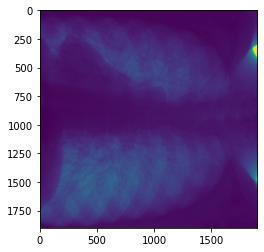

In [16]:
hd_ref = np.array(hd_ref)

#print resulting image
plt.imshow(hd_ref)
plt.show()

### Add a channel index at the end of each np.array

In [17]:
myrefs = [ref]
myhd_refs = [hd_ref]

#add a channel index at the end of each np.array
channel1 = np.expand_dims(ref, 2)
channel2 = np.expand_dims(hd_ref, 2)

## Using Keras' image_data_generator to create a dataset


>  Define each high dose and low dose samples variable as single image and add a dimension for each

> Image data augmentation generator

> Create the new dataset from the original slices of the images

> Storage arrays

> Instanciating the generator

> Add the instances to the storage arrays

> Normalising the image dataset (high and low dose)

In [18]:
#using Keras' image_data_generator to create a dataset

#define each high dose and low dose samples variable as single image and add a dimension for each
samples = np.expand_dims(channel1, 0)

samples_hd = np.expand_dims(channel2, 0)

#image data augmentation generator
datagen = ImageDataGenerator(rotation_range= 10, height_shift_range = 0.2, width_shift_range = 0.2, fill_mode = 'constant')

datagen.fit(samples)
datagen.fit(samples_hd)

# Create the new dataset from the original slices of the images

#storage arrays
clean=[] #high dose
noisy=[] #low dose

#instanciating the generator
inst = datagen.flow(samples, batch_size = 1)
inst_hd = datagen.flow(samples_hd, batch_size = 1)

#add the instances to the storage arrays
maxsize = 40
for i in range(maxsize): 
    new_image = inst.next()[0]
    new_image_hd = inst_hd.next()[0]

# normalising (high dose only)
    clean.append(new_image_hd.astype('float32')/np.max(new_image_hd))

#normalising (low dose only)
    noisy.append(new_image.astype('float32')/np.max(new_image))

## Re-shaping the sets so that they are in the sample, x, y, channel order

In [19]:
#re-shaping the sets so that they are in the sample, x, y, channel order
created_set = np.reshape(clean, [-1, 1900, 1900, 1])

noisycreated_set = np.reshape(noisy, [-1, 1900, 1900, 1])

## Show outputs

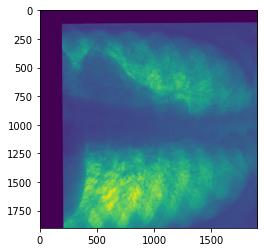

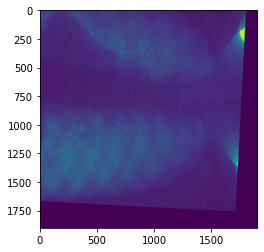

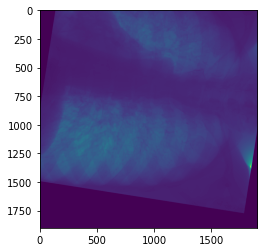

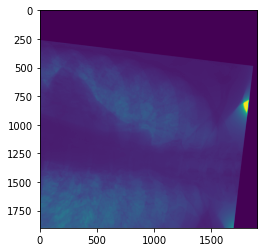

In [20]:
#Show outputs
plt.imshow(created_set[39,:,:,0]) #pic 99, channel 0
plt.show()

plt.imshow(noisycreated_set[39,:,:,0])
plt.show()

plt.imshow(created_set[27,:,:,0]) #pic 99, channel 0
plt.show()

plt.imshow(noisycreated_set[27,:,:,0])
plt.show()

## Splitting the dataset into training and test (80/20)

In [21]:
#splitting the dataset into training and test (80/20)
X_train, X_test = train_test_split(noisycreated_set, test_size = 0.2, random_state = 42)
y_train, y_test = train_test_split(created_set, test_size = 0.2, random_state = 42)

## Define custom SSIM Loss function

In [22]:
#define custom SSIM Loss function
def SSIMLoss(y_true, y_pred):
    """Defines a custom loss function for SSIM measurement models
    Arguments: y_true, the true data, and y_pred, calculated prediction
    Returns: SSIMLoss loss function
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

## Define autoencoders model

In [23]:
#network adapted from https://keras.io/examples/vision/autoencoder/

input = Input(shape = channel1.shape)

# Encoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
#x = MaxPooling2D((2, 2), padding="same")(x) #maxpooling seems to add unwanted fuzziness?
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x) #alternative to upscaling
# x = MaxPooling2D((2, 2), padding="same")(x)
#x = Conv2D(8, (3, 3), activation="relu", padding="same")(x) #try with and without extra layers
#x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
#x = Conv2DTranspose(8, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2D(1, (3, 3), activation="relu", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss=SSIMLoss)
#autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1900, 1900, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 1900, 1900, 32)    320       
                                                                 
 conv2d_1 (Conv2D)           (None, 1900, 1900, 16)    4624      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1900, 1900, 16)   2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 1900, 1900, 32)   4640      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 1900, 1900, 1)     289   

## Training the model

In [24]:
batch_size = 4
#training the model
history=autoencoder.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=10,
              shuffle=True,
              batch_size=batch_size)

Epoch 1/10
8/8 [==============================] - 224s 28s/step - loss: 0.7799 - val_loss: 0.5985
Epoch 2/10
8/8 [==============================] - 217s 27s/step - loss: 0.3986 - val_loss: 0.3186
Epoch 3/10
8/8 [==============================] - 220s 28s/step - loss: 0.3719 - val_loss: 0.2825
Epoch 4/10
8/8 [==============================] - 216s 27s/step - loss: 0.3152 - val_loss: 0.2857
Epoch 5/10
8/8 [==============================] - 217s 27s/step - loss: 0.3027 - val_loss: 0.2535
Epoch 6/10
8/8 [==============================] - 221s 28s/step - loss: 0.2946 - val_loss: 0.2507
Epoch 7/10
8/8 [==============================] - 215s 27s/step - loss: 0.2903 - val_loss: 0.2481
Epoch 8/10
8/8 [==============================] - 216s 27s/step - loss: 0.2893 - val_loss: 0.2502
Epoch 9/10
8/8 [==============================] - 220s 28s/step - loss: 0.2878 - val_loss: 0.2459
Epoch 10/10
8/8 [==============================] - 219s 28s/step - loss: 0.2915 - val_loss: 0.2455


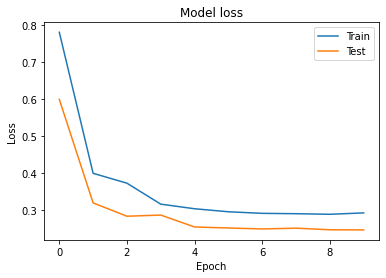

In [25]:
#plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.ylim([0, 1])
plt.show()

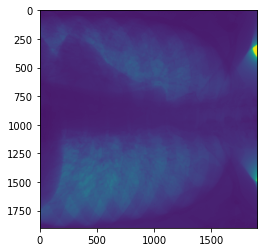

In [26]:
#predict the AE output from 'noisy' low dose test images
noisy_decoded = autoencoder.predict(samples)
plt.imshow(noisy_decoded.reshape(1900,1900))
plt.show()

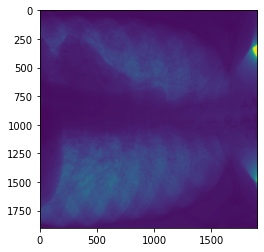

In [27]:
new_test_ref = reference[400:2300, 400:2300]
np.shape(new_test_ref)

plt.imshow(new_test_ref/np.max(new_test_ref))
plt.show()

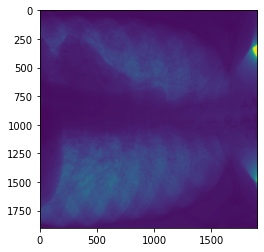

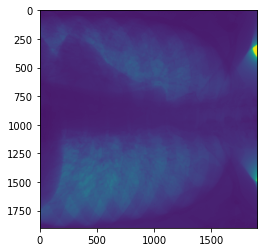

In [28]:
new_test_ref = np.array(new_test_ref)
new_test_ref = np.expand_dims(new_test_ref, 2)
new_test_ref = np.expand_dims(new_test_ref, 0)
new_test_ref.astype('float32')/np.max(new_test_ref)

new_decoded = autoencoder.predict(new_test_ref)

plt.imshow(new_test_ref.reshape(1900,1900))
plt.show()

plt.imshow(new_decoded.reshape(1900,1900))
plt.show()

In [29]:
def compare(imageA, imageB, title):

  psnr = peak_signal_noise_ratio(imageA, imageB) #, data_range = 255

  ssim = structural_similarity(imageA, imageB) #, multichannel=True, data_range = 255

  mse = mean_squared_error(imageA, imageB)

  nrmse = normalized_root_mse(imageA, imageB) #,  normalization='euclidean'

  # setup the figure
  fig = plt.figure(title)
  print('PSNR: %.6f, SSIM: %.6f, MSE: %.6f, NRMSE: %.6f' % (psnr, ssim, mse, nrmse))
  plt.suptitle('PSNR: %.6f, SSIM: %.6f, MSE: %.6f, NRMSE: %.6f' % (psnr, ssim, mse, nrmse))

  # show first image
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(imageA)
  plt.axis('off')

  # show the second image
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(imageB)
  plt.axis('off')

  # show the images
  plt.show()

  #return psnr, ssim, mse, nrmse

In [30]:
def sharpness_measure(imageA, imageB, title): 
  #adapted from https://dsp.stackexchange.com/questions/35490/how-to-locally-quantify-the-sharpness-of-an-image
    """function to show the sharpness of 2 side-by-side images as gradient maps
    Arguments: 2 images, title
    Returns: Plots of the 2 images with the difference in contrast (i.e., sharpness) measured by gradient
    """
    imageA_gray = rgb2gray(imageA)
    imageB_gray = rgb2gray(imageB)
    disk_matrix = disk(5) #matrix with a disk shape
    imageA_sharpness = gradient(imageA_gray, disk_matrix)
    imageB_sharpness = gradient(imageB_gray, disk_matrix)
    #Show first image
    plt.imshow(imageA_sharpness, cmap="viridis")
    plt.axis('off')
    plt.colorbar()
    plt.show()
    #show second image
    plt.imshow(imageB_sharpness, cmap="viridis")
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [31]:
np.max(ref)

11259

In [32]:
#Normalising images for comparison
Normalised_reference = hd_ref/np.max(hd_ref)
Normalised_decoded = noisy_decoded[0].reshape(1900, 1900)/np.max(noisy_decoded[0])
Normalised_noisy_original = ref/np.max(ref)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


PSNR: 43.794163, SSIM: 0.998873, MSE: 0.000042, NRMSE: 0.037334


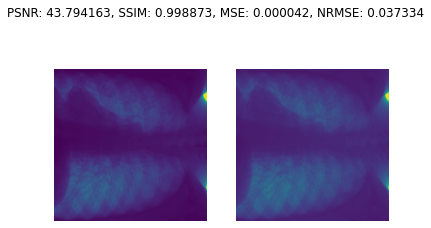

In [33]:
#Compare images clean reference with de-noised
compare(Normalised_reference, Normalised_decoded,"boo")
#for similarity want mse to be 0, ssim to be 1

PSNR: 47.325259, SSIM: 0.998668, MSE: 0.000019, NRMSE: 0.024863


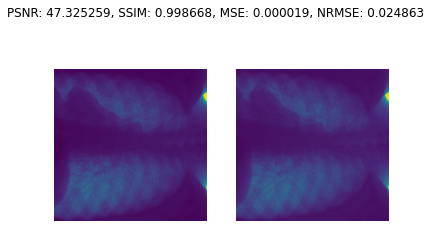

In [34]:
#Compare images clean reference with noisy original
compare(Normalised_reference, Normalised_noisy_original, "boo")

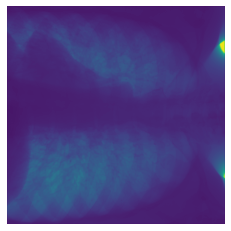

In [35]:
#save the decoded output image as as pdf
decodedimg = plt.figure()
plt.axis('off')
plt.imshow(Normalised_decoded)
plt.show()
decodedimg.savefig('decoded_dicom.pdf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning

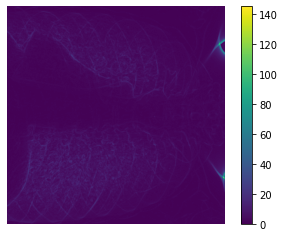

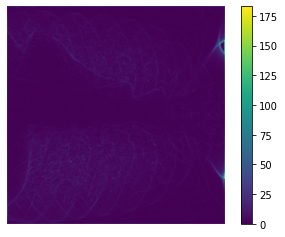

In [36]:
#image comparison for sharpness
sharpness_measure(Normalised_reference,Normalised_decoded, 'boo')

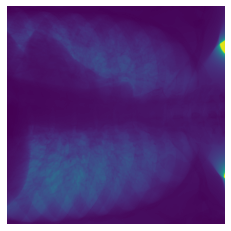

In [37]:
median_filter = ndimage.median_filter(ref, size= 5) 

# show first image
#ax = fig.add_subplot(1, 2, 1)
plt.imshow(median_filter)
plt.axis('off')

# show the images
plt.show()

PSNR: 49.668046, SSIM: 0.999241, MSE: 0.000011, NRMSE: 0.018985


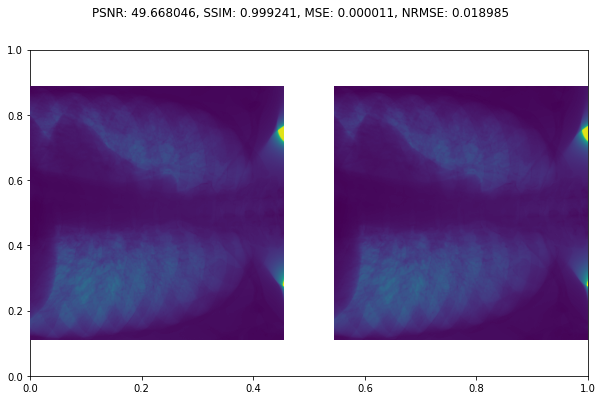

In [38]:
Normalised_median_filter = median_filter/np.max(median_filter)

#compare images clean reference image with filtered image by median_filter
plt.subplots(figsize=(10, 6))
compare (Normalised_reference, Normalised_median_filter,'')
#ideally want mse to be close to 0, ssim to be close to 1 

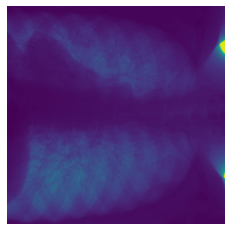

In [39]:
refb = ref.astype('float32')/np.max(ref)

bilateral_filter = cv2.bilateralFilter(refb,  5, 50, 50)

# show the second image
#ax = fig.add_subplot(1, 2, 2)
plt.imshow(bilateral_filter)
plt.axis('off')

# show the images
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


PSNR: 49.053728, SSIM: 0.999243, MSE: 0.000012, NRMSE: 0.020376


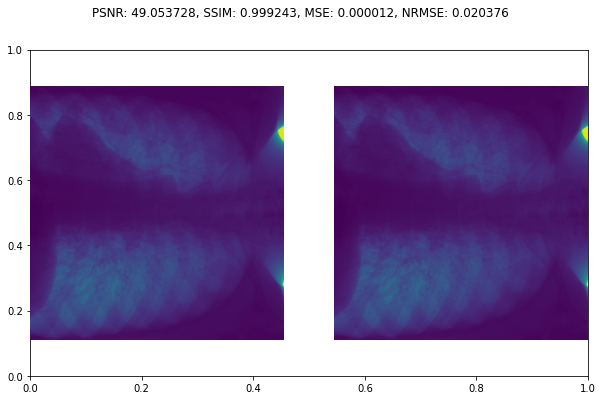

In [40]:
Normalised_bilateral_filter = bilateral_filter/np.max(bilateral_filter)

#compare images clean reference with filtered image by bilateral_filter
plt.subplots(figsize=(10, 6))
compare (Normalised_reference, Normalised_bilateral_filter,'')
#ideally want mse to be close to 0, ssim to be close to 1 